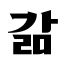

In [1]:
from PIL import Image

img = Image.open("/home/wonguk/coding/paper_project/hojun/data/62570_갊.png")
img

In [2]:
import torchvision
transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize((input_size,input_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
img = transforms(img)
img.shape


torch.Size([1, 64, 64])

In [3]:
import torch
img_batch = torch.unsqueeze(img,0)
img_batch = img_batch.repeat(8,1,1,1).to('cuda')
img_batch.shape

torch.Size([8, 1, 64, 64])

In [4]:
# t : torch.Size([8])
# char : torch.Size([8, 296])

t = torch.randn([8]).to('cuda')
char = torch.randn([8,296]).to('cuda')

In [8]:
import tensorrt as trt
import pycuda.driver as cuda
 
tensorrt_path = '/home/wonguk/coding/paper_project/hojun/light_weight/tensorrt.plan'
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
trt.init_libnvinfer_plugins(None, "")
with open(tensorrt_path, 'rb') as f:
    engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
context = engine.create_execution_context()

In [29]:
import pycuda.driver as cuda

cuda.init()
device = cuda.Device(0)
ctx = device.make_context()


# PyTorch 텐서를 NumPy 배열로 변환
img_batch_np = img_batch.cpu().numpy()
t_np = t.cpu().numpy()
char_np = char.cpu().numpy()

input_gpu1 = cuda.mem_alloc(img_batch_np.nbytes)
input_gpu2 = cuda.mem_alloc(t_np.nbytes)
input_gpu3 = cuda.mem_alloc(char_np.nbytes)

cuda.memcpy_htod(input_gpu1, img_batch_np)
cuda.memcpy_htod(input_gpu2, t_np )
cuda.memcpy_htod(input_gpu3, char_np)

input_gpu1.free()
input_gpu2.free()
input_gpu3.free()


In [30]:
bindings = [int(input_gpu1), int(input_gpu2), int(input_gpu3)]

with engine.create_execution_context() as context:
    context.execute_v2(bindings=bindings)

[10/11/2023-00:00:36] [TRT] [E] 1: [slice.cu::launchNaiveSliceImpl::245] Error Code 1: Cuda Runtime (invalid resource handle)


In [14]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit # 이걸로 gpu 초기화를 진행했는데 추가 에러 발생
from PIL import Image
import torchvision

img = Image.open("/home/wonguk/coding/paper_project/hojun/data/62570_갊.png")
transforms = torchvision.transforms.Compose([
        # torchvision.transforms.Resize((input_size,input_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
img = transforms(img)
img_batch = torch.unsqueeze(img,0)
img_batch = img_batch.repeat(8,1,1,1).to('cuda')

t = torch.randn([8]).to('cuda')
char = torch.randn([8,296]).to('cuda')

tensorrt_path = '/home/wonguk/coding/paper_project/hojun/light_weight/tensorrt.plan'
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
trt.init_libnvinfer_plugins(None, "")
with open(tensorrt_path, 'rb') as f:
    engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)

context = engine.create_execution_context()

# CUDA 메모리 할당
input_gpu1 = cuda.mem_alloc(img_batch.element_size() * img_batch.nelement())
input_gpu2 = cuda.mem_alloc(t.element_size() * t.nelement())
input_gpu3 = cuda.mem_alloc(char.element_size() * char.nelement())

# CUDA 메모리에 데이터 복사
cuda.memcpy_htod(input_gpu1, img_batch.cpu().numpy().tobytes())
cuda.memcpy_htod(input_gpu2, t.cpu().numpy().tobytes())
cuda.memcpy_htod(input_gpu3, char.cpu().numpy().tobytes())

input_gpu1.free()
input_gpu2.free()
input_gpu3.free()

bindings = [int(input_gpu1), int(input_gpu2), int(input_gpu3)]
context.execute_v2(bindings=bindings)

[10/

False

11/2023-00:41:15] [TRT] [E] 1: [convolutionRunner.cpp::executeConv::465] Error Code 1: Cudnn (CUDNN_STATUS_BAD_PARAM)
